In [4]:
import pandas as pd
from pathlib import Path
from plots.loader import get_subfolders, load_multiple_timings, load_algorithm

folders = get_subfolders(Path("measurements/nlpkkt240/scalability/new-36"))
folders = [folder for folder in folders if load_algorithm(folder) == 'drop_parallel']
# Returns the matrix name and a dictionary of mapping from function to dataframe
matrix, ft = load_multiple_timings(folders)
assert len(ft) == 1
assert 'drop_parallel' in ft

In [5]:
drop = ft['drop_parallel']
drop

,func,duration,bytes,node_id,nodes,mpi
0,partition,14917600.0,0,0,32,32
0,build_csr,28767800.0,0,31,32,32
1,build_csr,206025.0,0,31,32,32
2,build_csr,198830.0,0,31,32,32
3,build_csr,186238.0,0,31,32,32
...,...,...,...,...,...,...
25545,deserialize,6708.0,0,511,512,512
25546,deserialize,6578.0,0,511,512,512
25547,deserialize,6636.0,0,511,512,512
25548,deserialize,6817.0,0,511,512,512


In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

# SCALING_FACTOR = 10**9 # for seconds
SCALING_FACTOR = 10**6
runs = 50
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
pretty_name = 'Ours'
color = 'dodgerblue'

   key         avg          min         max
0   32  1468.86380  1447.195000  1483.88675
1   64  1094.49660  1078.130250  1101.14650
2  128   908.02110   868.568825   936.31455
3  256   798.59174   780.198500   826.12790
4  512   804.97592   790.744400   828.76910


Text(0.5, 1.0, 'Squaring computation on \\texttt{nlpkkt240}')

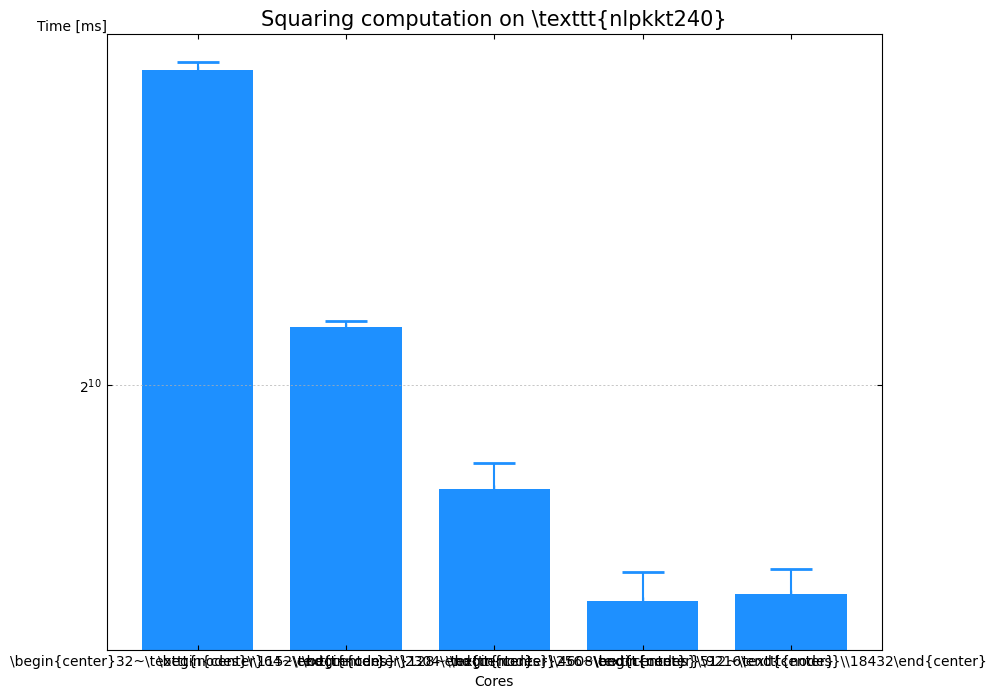

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

timings = []
for key, group in drop.groupby('mpi'):
    gemm_s = group[group['func'] == 'gemm']['duration']
    gemm = gemm_s.mean()/SCALING_FACTOR
    
    timings.append({
        "key": key,
        "avg": gemm,
        "min": min(gemm_s.quantile(0.025)/SCALING_FACTOR, gemm),
        "max": max(gemm_s.quantile(0.975)/SCALING_FACTOR, gemm)
    })

timings = pd.DataFrame(timings)

print(timings)
# Calculate the error bars
eb = [
    (timings['avg'] - timings['min']),
    (timings['max'] - timings['avg'])
]

keys = timings["key"]
keysi = range(len(keys))
values = timings["avg"]
ax.bar(keysi, values, 0.75, label='GEMM', color=color)
ax.errorbar(keysi, values, yerr=eb, fmt='|', capsize=15, capthick=2, label=pretty_name, color=color)

ax.set_xlabel("Cores")
ax.set_ylabel('Time [ms]',
        rotation='horizontal',
        loc='top',
        labelpad=-20)
ax.set_xticks(keysi, labels=[f"\\begin{{center}}{mpi}~\\texttt{{nodes}}\\\\{mpi * 36}\\end{{center}}"for mpi in keys])

plt.yscale('log', base=2)
ax.tick_params(axis='both', direction='in', which='major')
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_title("Squaring computation on \\texttt{" + matrix + "}", fontsize=15)